In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
import os
import scanpy as sc
%matplotlib inline

In [8]:
import pandas as pd
import numpy as np 
###### read in this tsv .to_csv('/data/tbaharav/umi_dylan/umi_analysis/umi_probs_length_5.tsv', sep='\t', header=False, index=False)
umi_probs = pd.read_csv('/data/tbaharav/umi_dylan/umi_analysis/umi_probs_length_5.tsv', sep='\t', header=None)
umi_probs.columns = ['umi', 'prob']

In [9]:
umi_prob_arr = np.array(umi_probs['prob'])

In [10]:
umi_probs

,umi,prob
0,TTTTT,0.004044
1,CTTTT,0.002864
2,ATTTT,0.002794
3,TTTAT,0.002710
4,TTTTA,0.002665
...,...,...
1019,GGAGG,0.000396
1020,GAGCG,0.000384
1021,GGAGA,0.000379
1022,GGGAG,0.000375


In [11]:
######## forward model for computing expected number of collided UMIs given true n_umis, and an empirical distribution of UMI probabilities
def compute_non_unif_estimator(umi_prob_arr, n_umis_true,K):
    """
    Compute the estimator for non-collided UMI counts.
    
    Parameters:
    umi_prob_arr (numpy.ndarray): Array of UMI probabilities.
    n_umis_true (int): True number of UMIs.
    K (int): Total number of UMIs.
    """
    
    assert len(umi_prob_arr) == K, "Length of umi_prob_arr must be equal to K"
    # assert n_umis_true <= K, "n_umis_true must be less than or equal to K"
    
    # Compute the expected number of UMIs from collisions
    
    return K - np.sum( (1-umi_prob_arr)**n_umis_true )
    
    
def compute_naive_unif_estimator(n_umis_true, K):
    """
    Compute the naive estimator for non-collided UMI counts.
    """
    return K * (1 - (1 - 1 / K)**n_umis_true)

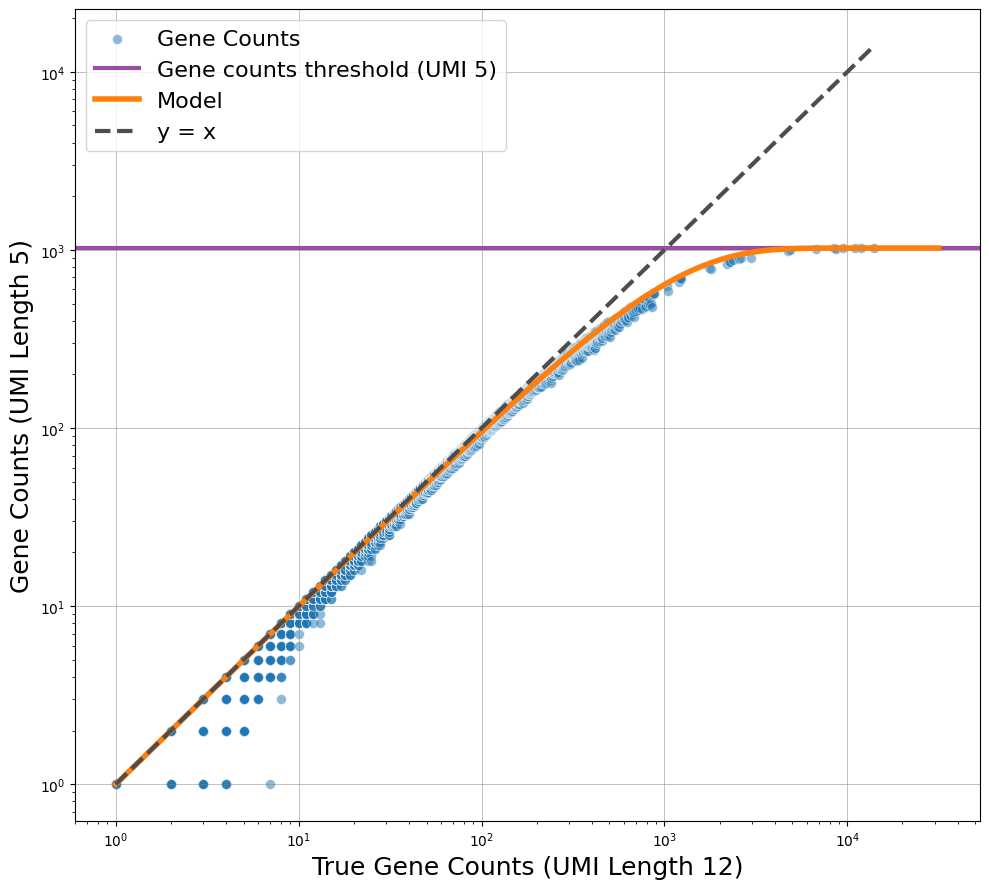

In [6]:
###### Dylan initial plotting code

directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"  # Directory for 1k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/"  # Directory for 1k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/adata_matrices/"    # Directory for 10k PBMCS

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")
    
    
# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Fixed comparison UMI length
barcode = "CTACAGACAACAAAGT-1"
n_values = np.logspace(0, 4.5, 200)

min_ct_threshold = 1

# Output directory
# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/counts_plots/naive"
# os.makedirs(save_dir, exist_ok=True)

# Find the barcode index
# index_i = np.where(adata_dict[i].obs_names == barcode)[0][0]
# index_j = np.where(adata_dict[j].obs_names == barcode)[0][0]

# # Extract and process counts
# gene_counts_i = adata_dict[i].X[index_i].flatten()
# gene_counts_j = adata_dict[j].X[index_j].flatten()

gene_counts_i = adata_dict[i].X.flatten()
gene_counts_j = adata_dict[j].X.flatten()

mask = gene_counts_i >= min_ct_threshold
gene_counts_i = gene_counts_i[mask]
gene_counts_j = gene_counts_j[mask]

sorted_idx = np.argsort(gene_counts_i)
sorted_gene_counts_i = gene_counts_i[sorted_idx] #+ 1
sorted_gene_counts_j = gene_counts_j[sorted_idx] #+ 1

# Create plot
plt.figure(figsize=(10, 9))
plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')

y_asymptotic_value = 4**j
plt.axhline(y=y_asymptotic_value, color='#984ea3', linestyle='-', linewidth=3, label=f'Gene counts threshold (UMI {j})')

model_vals = f(n_values, j)
plt.plot(n_values, model_vals, color='#ff7f0e', linewidth=4, label='Model')

######### also plot results from compute_non_unif_estimator
# K = 4**j
# non_unif_prediction = [compute_non_unif_estimator(umi_prob_arr, n, K) for n in n_values]
# plt.plot(n_values, non_unif_prediction, color='#2ca02c', linewidth=4, label='Non-uniform estimator')



max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_i.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=3, label='y = x')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Gene Counts (UMI Length {j})', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(fontsize=16)
plt.tight_layout()

plt.show()



In [30]:
import scanpy as sc
fpath = '/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/results_auto/outs/filtered_feature_bc_matrix'  # 1k
adata_cr = sc.read_10x_mtx(fpath)



adata_5 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/adata_5.h5ad")
adata_5

import scipy.sparse

# For adata_cr (sparse → dense)
if scipy.sparse.issparse(adata_cr.X):
    adata_cr.X = adata_cr.X.toarray()

# For adata_5 (already dense, so nothing needed)
if scipy.sparse.issparse(adata_5.X):
    adata_5.X = adata_5.X.toarray()


In [31]:
print(type(adata_cr.X))      # likely: <class 'scipy.sparse.csc.csc_matrix'>
print(type(adata_5.X)) 

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [32]:
# Identify intersection of gene names
common_genes = adata_cr.var_names.intersection(adata_5.var_names)

# Use common genes
adata_cr_sub = adata_cr[:, common_genes].copy()
adata_5_sub = adata_5[:, common_genes].copy()

# Verify Shape
adata_cr_sub  
# adata_5_sub

AnnData object with n_obs × n_vars = 1232 × 26730
    var: 'gene_ids', 'feature_types'

In [ ]:
### plotting u[5] vs cellranger

/tmp/ipykernel_1232440/2253022601.py:68: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/data/dagyeman/miniconda3/envs/af/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


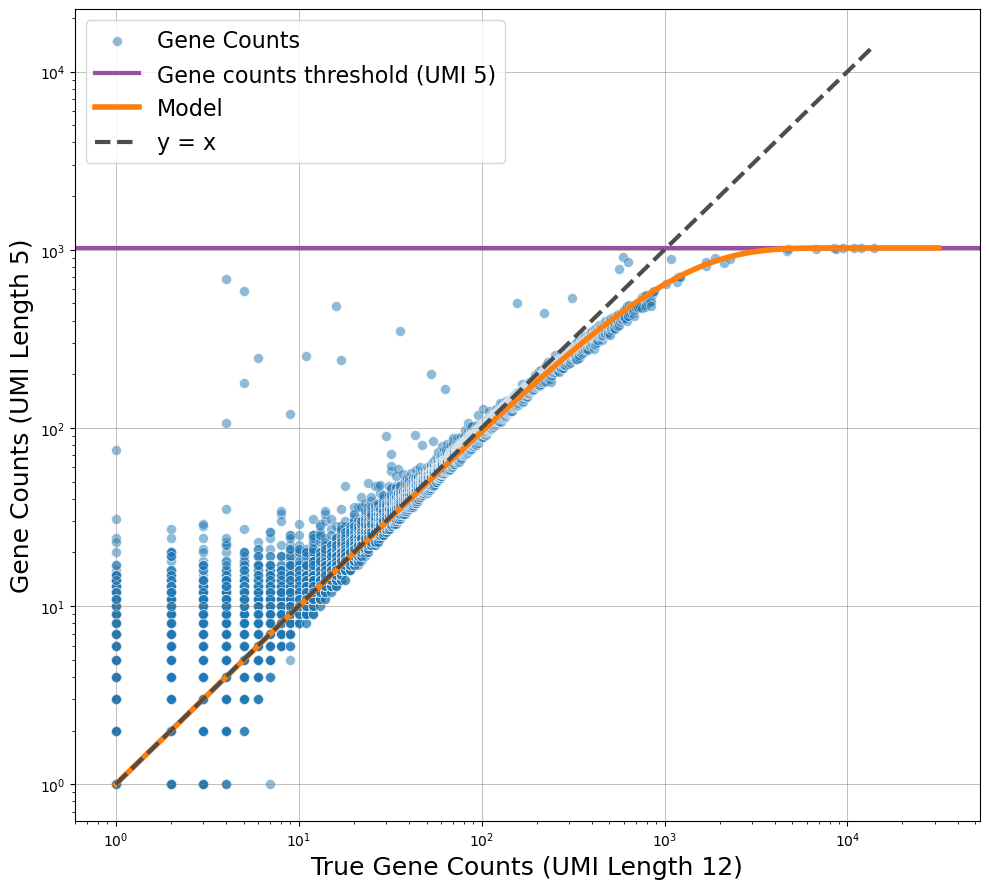

In [36]:
###### Dylan initial plotting code
import matplotlib.pyplot as plt

    
    
# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Fixed comparison UMI length
barcode = "CTACAGACAACAAAGT-1"
n_values = np.logspace(0, 4.5, 200)

min_ct_threshold = 1

# Output directory
# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/counts_plots/naive"
# os.makedirs(save_dir, exist_ok=True)

# Find the barcode index
# index_i = np.where(adata_dict[i].obs_names == barcode)[0][0]
# index_j = np.where(adata_dict[j].obs_names == barcode)[0][0]

# # Extract and process counts
# gene_counts_i = adata_dict[i].X[index_i].flatten()
# gene_counts_j = adata_dict[j].X[index_j].flatten()

gene_counts_i = adata_cr_sub.X.flatten()
gene_counts_j = adata_5_sub.X.flatten()

mask = gene_counts_i >= min_ct_threshold
gene_counts_i = gene_counts_i[mask]
gene_counts_j = gene_counts_j[mask]

sorted_idx = np.argsort(gene_counts_i)
sorted_gene_counts_i = gene_counts_i[sorted_idx] #+ 1
sorted_gene_counts_j = gene_counts_j[sorted_idx] #+ 1

# Create plot
plt.figure(figsize=(10, 9))
plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')

y_asymptotic_value = 4**j
plt.axhline(y=y_asymptotic_value, color='#984ea3', linestyle='-', linewidth=3, label=f'Gene counts threshold (UMI {j})')

model_vals = f(n_values, j)
plt.plot(n_values, model_vals, color='#ff7f0e', linewidth=4, label='Model')

######### also plot results from compute_non_unif_estimator
# K = 4**j
# non_unif_prediction = [compute_non_unif_estimator(umi_prob_arr, n, K) for n in n_values]
# plt.plot(n_values, non_unif_prediction, color='#2ca02c', linewidth=4, label='Non-uniform estimator')



max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_i.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=3, label='y = x')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Gene Counts (UMI Length {j})', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(fontsize=16)
plt.tight_layout()

plt.show()


In [40]:
###### center plot by subtracting model_vals
K = 4**j
plt.figure()
naive_pred = f(sorted_gene_counts_i,j)
opt_pred = np.array([compute_non_unif_estimator(umi_prob_arr, n, K) for n in sorted_gene_counts_i])
# plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - opt_pred, alpha=0.5, 
#             c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')
# plt.plot(sorted_gene_counts_i, naive_pred - opt_pred, color='#ff7f0e', linewidth=4, label='uniform minus non-uniform predictions')

<Figure size 640x480 with 0 Axes>

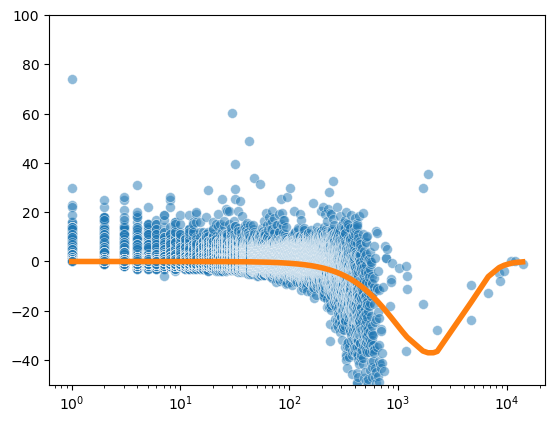

In [41]:
plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - naive_pred, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts - Naive')
plt.plot(sorted_gene_counts_i, opt_pred-naive_pred, color='#ff7f0e', linewidth=4, label='non_uniform minus naive predictions')
plt.ylim(-50, 100)  # Adjust range as needed

plt.xscale('log')

In [42]:
###### center by subtracting model_vals
plt.figure()
naive_pred = f(sorted_gene_counts_i,j)
opt_pred = np.array([compute_non_unif_estimator(umi_prob_arr, n, K) for n in sorted_gene_counts_i])
# plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - opt_pred, alpha=0.5, 
#             c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')
# plt.plot(sorted_gene_counts_i, naive_pred - opt_pred, color='#ff7f0e', linewidth=4, label='uniform minus non-uniform predictions')



<Figure size 640x480 with 0 Axes>

In [ ]:
plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - naive_pred, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts - Naive')
plt.plot(sorted_gene_counts_i, opt_pred-naive_pred, color='#ff7f0e', linewidth=4, label='non_uniform minus naive predictions')
plt.ylim(-50, 100) 

plt.xscale('log')


In [ ]:
############# validate that non-uniform model accurately predicts results when data is generated from this model


umi_probs_12 = pd.read_csv('/data/tbaharav/umi_dylan/umi_analysis/umi_counts_overall.tsv', sep='\t', header=None)
umi_probs_12.columns = ['umi', 'counts']
umi_probs_12['prob'] = umi_probs_12['counts'] / umi_probs_12['counts'].sum()


In [9]:
######### generate a fake dataset:

def gen_synthetic_gene(umi_probs, n_umis_true, k=5):
    """
    Generate a synthetic gene expression dataset based on UMI probabilities.
    
    Parameters:
    umi_probs (pd.DataFrame): DataFrame containing UMI probabilities.
    n_umis_true (int): True number of UMIs.
    k (int): Length of UMIs to consider.
    
    Returns:
    pd.DataFrame: Synthetic gene expression dataset.
    """
    
    # Generate random UMIs based on the given probabilities
    umis = np.random.choice(umi_probs['umi'], size=n_umis_true, p=umi_probs['counts']/umi_probs['counts'].sum())
    
    length_12_counts = len(np.unique(umis))
    k = 5  # or set k as a function argument if you want it flexible
    truncated_umis = [umi[:k] for umi in umis]
    length_k_counts = len(np.unique(truncated_umis))
    
    return length_12_counts, length_k_counts
    


In [45]:
from tqdm import tqdm

np.random.seed(0)
# n_true_to_use = np.arange(1, 1000, 10)
n_true_to_use = np.logspace(0, np.log10(40000), 200, dtype=int)
####### add lots of points in logspace between n_extra_min and n_extra_max
n_extra_min = 90
n_extra_max = 6000
n_extra = np.logspace(np.log10(n_extra_min), np.log10(n_extra_max), 100, dtype=int)

### more extra points
n_extra_2 = np.logspace(np.log10(800), np.log10(4000), 200, dtype=int)

n_true_to_use = np.concatenate((n_true_to_use, n_extra, n_extra_2))

n_true_to_use = np.unique(n_true_to_use)
## sort
n_true_to_use = np.sort(n_true_to_use)

k=5
K=4**k

length_12_counts = []
length_k_counts = []
unif_estimator = []
non_unif_estimator = []

for n_umis_true in tqdm(n_true_to_use):
    len_12_ct, len_k_ct = gen_synthetic_gene(umi_probs_12, n_umis_true, k)
    length_12_counts.append(len_12_ct)
    length_k_counts.append(len_k_ct)
    unif_estimator.append(compute_naive_unif_estimator(n_umis_true, K))
    non_unif_estimator.append(compute_non_unif_estimator(umi_prob_arr, n_umis_true, K))
# Convert to numpy arrays
length_12_counts = np.array(length_12_counts)
length_k_counts = np.array(length_k_counts)
unif_estimator = np.array(unif_estimator)
non_unif_estimator = np.array(non_unif_estimator)


100%|██████████| 445/445 [00:41<00:00, 10.73it/s]


In [46]:
(length_12_counts-n_true_to_use)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   -1,    0,    0,    0,    0,    0,
          0,   -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   -1,    0,    0,    0,    0,   

/tmp/ipykernel_2748609/3546742822.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothed[i] = x_point @ coeffs
/tmp/ipykernel_2748609/3546742822.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothed[i] = x_point @ coeffs
/tmp/ipykernel_2748609/3546742822.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothed[i] = x_point @ coeffs
/tmp/ipykernel_2748609/3546742822.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Text(0, 0.5, 'Collided Gene Counts (UMI Length 5) - Uniform Estimator')

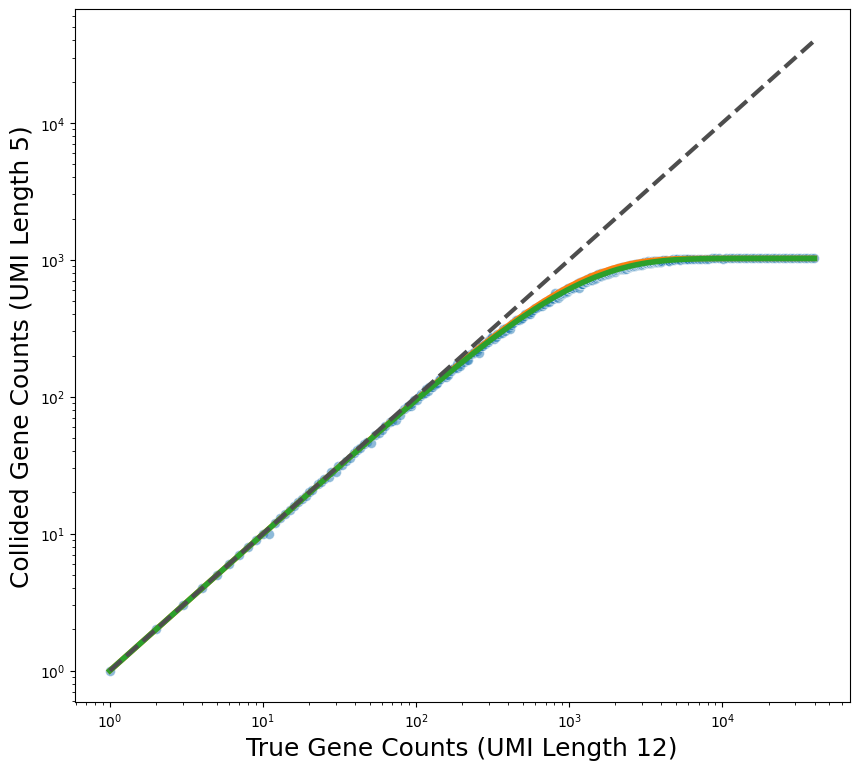

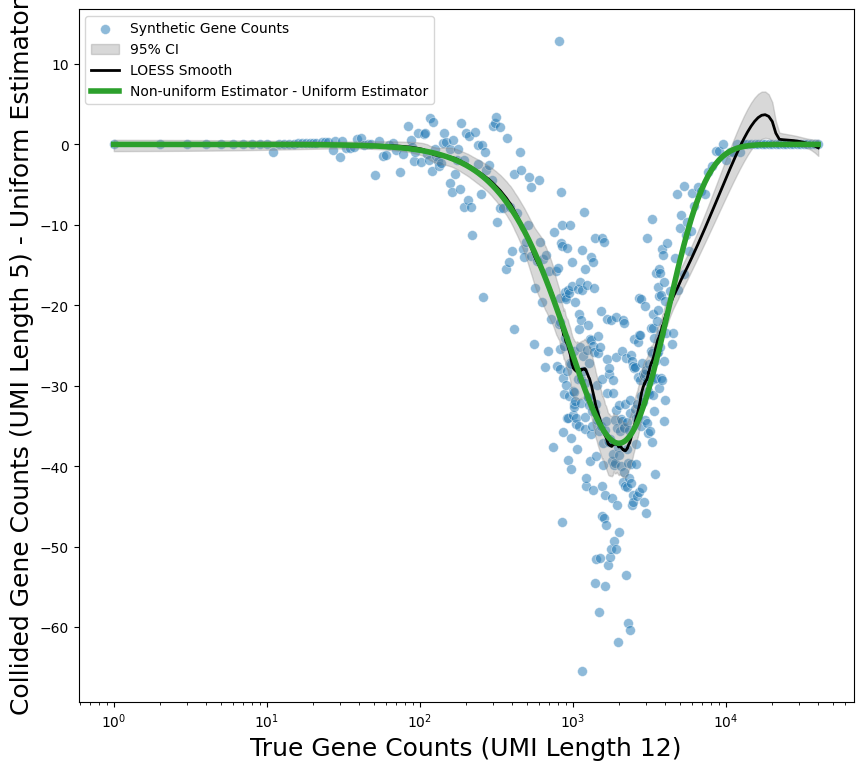

In [50]:
#### plot all
plt.figure(figsize=(10, 9))
# data
plt.scatter(length_12_counts, length_k_counts, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Synthetic Gene Counts')
### unif model
plt.plot(length_12_counts, unif_estimator, color='#ff7f0e', linewidth=4, label='Uniform Estimator')
### non-unif model
plt.plot(length_12_counts, non_unif_estimator, color='#2ca02c', linewidth=4, label='Non-uniform Estimator')
### y=x line
plt.plot([1, length_12_counts.max()], [1, length_12_counts.max()], linestyle='--', color='#4D4D4D', linewidth=3, label='y = x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Collided Gene Counts (UMI Length {k})', fontsize=18)




##### plot differences, subtract the "uniform prediction" from everything
plt.figure(figsize=(10, 9))
plt.scatter(length_12_counts, length_k_counts - unif_estimator, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Synthetic Gene Counts')


# Usage
x_smooth, y_smooth, ci_low, ci_high = loess_smooth(
    n_true_to_use, 
    length_k_counts - unif_estimator, 
    degree=2,
    frac=0.2
)

plt.fill_between(x_smooth, ci_low, ci_high, alpha=0.3, color='gray', label='95% CI')
plt.plot(x_smooth, y_smooth, color='black', linewidth=2, label='LOESS Smooth')

# # Compute and plot moving average (window size = 7, can adjust)
# window = 15
# if len(n_true_to_use) >= window:
#     # Sort by n_true_to_use just in case
#     sort_idx = np.argsort(n_true_to_use)
#     x_sorted = n_true_to_use[sort_idx]
#     y_sorted = (length_k_counts - unif_estimator)[sort_idx]
#     y_ma = np.convolve(y_sorted, np.ones(window)/window, mode='valid')
#     x_ma = x_sorted[(window//2):-(window//2)] if window % 2 == 1 else x_sorted[(window//2-1):-(window//2)]
#     plt.plot(x_ma, y_ma, color='black', linewidth=2, label=f'Moving Avg (window={window})')
plt.plot(length_12_counts, non_unif_estimator - unif_estimator, color='#2ca02c', linewidth=4, label='Non-uniform Estimator - Uniform Estimator')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Collided Gene Counts (UMI Length {k}) - Uniform Estimator', fontsize=18)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pandas as pd

def loess_smooth(x, y, frac=0.3, degree=1, return_ci=True, alpha=0.05):
    """
    LOESS smoothing with optional confidence intervals
    
    Parameters:
    - frac: fraction of data to use for each local regression
    - degree: polynomial degree (1=linear, 2=quadratic)
    - return_ci: whether to compute confidence intervals
    - alpha: significance level for CI (0.05 = 95% CI)
    """
    # Sort data
    sort_idx = np.argsort(x)
    x_sorted, y_sorted = x[sort_idx], y[sort_idx]
    
    n = len(x_sorted)
    smoothed = np.zeros(n)
    if return_ci:
        ci_lower = np.zeros(n)
        ci_upper = np.zeros(n)
    
    # LOESS smoothing
    for i in range(n):
        # Define local neighborhood
        h = int(np.ceil(frac * n))
        start = max(0, i - h//2)
        end = min(n, start + h)
        if end - start < h:
            start = max(0, end - h)
        
        # Local regression
        x_local = x_sorted[start:end]
        y_local = y_sorted[start:end]
        
        # Weights (tricube kernel)
        distances = np.abs(x_local - x_sorted[i])
        max_dist = np.max(distances)
        if max_dist > 0:
            weights = (1 - (distances / max_dist)**3)**3
            weights[distances > max_dist] = 0
        else:
            weights = np.ones(len(x_local))
        
        # Weighted polynomial regression
        if degree == 1:
            X = np.column_stack([np.ones(len(x_local)), x_local])
        else:
            poly = PolynomialFeatures(degree=degree)
            X = poly.fit_transform(x_local.reshape(-1, 1))
        
        # Weighted least squares
        W = np.diag(weights)
        try:
            coeffs = np.linalg.solve(X.T @ W @ X, X.T @ W @ y_local)
            if degree == 1:
                smoothed[i] = coeffs[0] + coeffs[1] * x_sorted[i]
            else:
                x_point = poly.transform(x_sorted[i].reshape(-1, 1))
                smoothed[i] = x_point @ coeffs
            
            # Confidence intervals
            if return_ci:
                residuals = y_local - X @ coeffs
                mse = np.sum(weights * residuals**2) / np.sum(weights)
                if degree == 1:
                    x_design = np.array([1, x_sorted[i]])
                else:
                    x_design = x_point.flatten()
                
                var_pred = mse * x_design.T @ np.linalg.inv(X.T @ W @ X) @ x_design
                t_val = stats.t.ppf(1 - alpha/2, len(x_local) - degree - 1)
                margin = t_val * np.sqrt(var_pred)
                ci_lower[i] = smoothed[i] - margin
                ci_upper[i] = smoothed[i] + margin
                
        except np.linalg.LinAlgError:
            smoothed[i] = np.average(y_local, weights=weights)
            if return_ci:
                ci_lower[i] = ci_upper[i] = smoothed[i]
    
    if return_ci:
        return x_sorted, smoothed, ci_lower, ci_upper
    return x_sorted, smoothed
